# Organic & Recyclable Waste Image Classification

## Introduction and objectives

The choosen dataset is the Waste Classification Data [available on Kaggle](https://www.kaggle.com/techsash/waste-classification-data). The dataset was created by Sashaank Sekar, containing 25077 images of organic waste and recyclable waste, divided into a training set (85%) and testing set (15%). To introduce a little more variability and even class balance more images were added from [Arkadiy Serezhkin's dataset](https://www.kaggle.com/arkadiyhacks/drinking-waste-classification) - 2560 for training and 228 for testing. 

The images are various type of common urban waste, some personally created by the authors but mostly quite likelly collected online - which could impose some misclassifications if an image contains several different, unrelated objects, or portrays a magazine with a human face on the cover.

The stated problem is simple, to classify an image if it is either organic or recyclable waste - a binary classification. The labels are 0 for organic, 1 for recyclable.

### Objectives

Modeling - try 4-5 approaches

* Define a model (network architecture)
* Pick some hyperparameters
* Train the model
* Make predictions on samples
* Evaluate on test dataset
* Save the model weights
* Record the metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [3]:
# Project name used for jovian.commit
project_name = 'OR-Waste-Classif'

In [4]:
# Data transformations before loading data
transformations = transforms.Compose([
    transforms.Resize(size=(50, 50)),
    transforms.ToTensor()])#,
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
dataset = ImageFolder(root='./DATASET/TRAIN/', transform=transformations)
test_dataset = ImageFolder(root='./DATASET/TEST/', transform=transformations)

### Data preparation and input

In [6]:
len(dataset), len(test_dataset)

(25124, 2741)

In [7]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([3, 50, 50]) 0


Label: 0


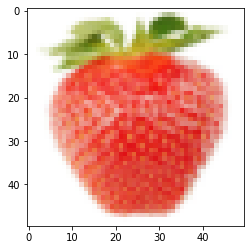

In [8]:
image, label = dataset[0]
plt.imshow(image.permute(1, 2, 0))
print('Label:', label)

In [9]:
classes = dataset.classes

In [10]:
for set in [dataset, test_dataset]:
    counts = dict()
    for image, label in set:
        counts[classes[label]] = counts.get(classes[label], 0) + 1
    print(counts)

{'O': 12565, 'R': 12559}
{'O': 1401, 'R': 1340}


In [11]:
torch.manual_seed(123)
val_size = 1260
train_size = len(dataset) - val_size

In [12]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(23864, 1260)

In [13]:
# Hyperparmeters
batch_size = 128
epochs = 10
learning_rate = 0.001

# Other constants
input_size = 3*50*50
num_classes = 2
opt_func = torch.optim.SGD

In [14]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 50, 50])


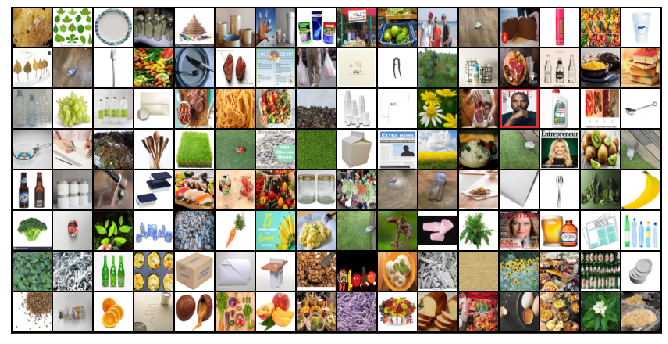

In [15]:
def show_batch(dataset_loader):
    for images, labels in dataset_loader:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

## Baseline - Simple Logistic Model

In [16]:
# Logistic Model
class WasteLogistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        #xb = xb.reshape(-1, 3*100*100)
        xb = torch.flatten(xb, start_dim=1, end_dim=-1)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = WasteLogistModel()

In [17]:
# Training
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
evaluate(model, val_loader)

{'val_loss': 0.7416515350341797, 'val_acc': 0.4957759380340576}

In [19]:
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5532, val_acc: 0.7297
Epoch [1], val_loss: 0.5120, val_acc: 0.7595
Epoch [2], val_loss: 0.5032, val_acc: 0.7656
Epoch [3], val_loss: 0.5059, val_acc: 0.7567
Epoch [4], val_loss: 0.5014, val_acc: 0.7635
Epoch [5], val_loss: 0.5312, val_acc: 0.7529
Epoch [6], val_loss: 0.4965, val_acc: 0.7644
Epoch [7], val_loss: 0.4974, val_acc: 0.7697
Epoch [8], val_loss: 0.4942, val_acc: 0.7740
Epoch [9], val_loss: 0.5132, val_acc: 0.7583


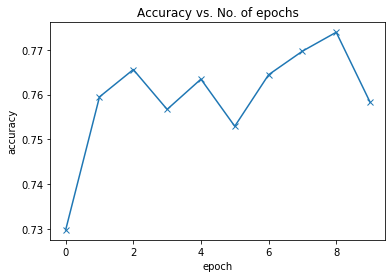

In [20]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [21]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.400386244058609, 'val_acc': 0.845276415348053}

In [22]:
# Predicting images and presenting
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted: 1


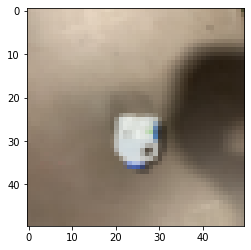

In [23]:
img, label = test_dataset[1548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

#### Save and Commit

In [25]:
torch.save(model.state_dict(), 'waste-logist.pth')

In [26]:
!pip install jovian --upgrade --quiet

In [27]:
import jovian

In [28]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': learning_rate,
})

[jovian] Hyperparams logged.


In [31]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [32]:
jovian.commit(project=project_name, environment=None, outputs=['waste-logist.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "dan-motp/OR-Waste-Classif"
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/or-waste-classif


'https://jovian.ml/dan-motp/or-waste-classif'

## Using GPU device

In [33]:
torch.cuda.is_available()

True

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Simple FeedForward with hidden layers

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class WasteClassBase(nn.Module):    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [38]:
class WasteFFModel(WasteClassBase):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 64) # hidden layer
        self.linear2 = nn.Linear(64, 128) # hidden layer 2
        self.linear3 = nn.Linear(128, out_size) # output layer
        
    def forward(self, xb):
        
        out = torch.flatten(xb, start_dim=1, end_dim=-1) # Flatten the image tensors
        out = self.linear1(out) # Get intermediate outputs using hidden layer 1
        out = F.relu(out)       # Apply activation function
        out = self.linear2(out) # Get intermediate outputs using hidden layer 2
        out = F.relu(out)       # Apply activation function
        out = self.linear3(out) # Get predictions using output layer
        return out

### Training

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
model = WasteFFModel(input_size, out_size=num_classes)
to_device(model, device)

WasteFFModel(
  (linear1): Linear(in_features=7500, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
)

In [41]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6970810294151306, 'val_acc': 0.48548728227615356}]

In [42]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6692, val_loss: 0.6528, val_acc: 0.6579
Epoch [1], train_loss: 0.6261, val_loss: 0.6111, val_acc: 0.7318
Epoch [2], train_loss: 0.5852, val_loss: 0.5753, val_acc: 0.7429
Epoch [3], train_loss: 0.5527, val_loss: 0.5495, val_acc: 0.7492
Epoch [4], train_loss: 0.5302, val_loss: 0.5311, val_acc: 0.7394
Epoch [5], train_loss: 0.5169, val_loss: 0.5216, val_acc: 0.7519
Epoch [6], train_loss: 0.5082, val_loss: 0.5137, val_acc: 0.7480
Epoch [7], train_loss: 0.5024, val_loss: 0.5090, val_acc: 0.7562
Epoch [8], train_loss: 0.4984, val_loss: 0.5062, val_acc: 0.7610
Epoch [9], train_loss: 0.4955, val_loss: 0.5041, val_acc: 0.7543


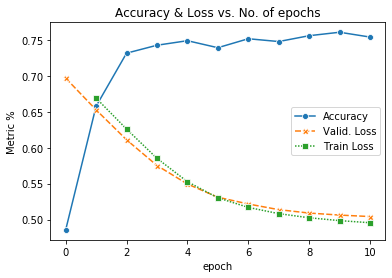

In [43]:
def plot_metrics(history):
    metrics = pd.DataFrame({'Accuracy': [x['val_acc'] for x in history], 
                            'Valid. Loss': [x['val_loss'] for x in history],
                           'Train Loss': [x.get('train_loss') for x in history]})

    sns.lineplot(data=metrics, markers=True, hue=metrics.columns)

    plt.xlabel('epoch')
    plt.ylabel('Metric %')
    plt.legend(['Accuracy', 'Valid. Loss', 'Train Loss'])
    plt.title('Accuracy & Loss vs. No. of epochs');
    
plot_metrics(history)

In [44]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device) # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    _, preds  = torch.max(yb, dim=1) # Pick index with highest probability
    return dataset.classes[preds[0].item()]

Label: O , Predicted: R


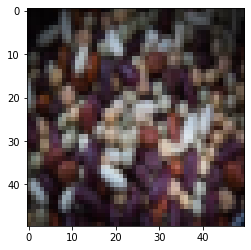

In [45]:
# Testing samples
img, label = test_dataset[950]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [46]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.43281883001327515, 'val_acc': 0.8303459286689758}

#### Save and Commit

In [48]:
torch.save(model.state_dict(), 'waste-ff.pth')

In [49]:
!pip install jovian --upgrade --quiet

In [50]:
import jovian

In [51]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': learning_rate,
})

[jovian] Hyperparams logged.


In [53]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [54]:
jovian.commit(project=project_name, environment=None, outputs=['waste-ff.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/or-waste-classif" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/or-waste-classif


'https://jovian.ml/dan-motp/or-waste-classif'

## Simple CNN Model

In [55]:
# Clearing CUDA memory cache
torch.cuda.empty_cache()

In [56]:
class WasteCnnModel(WasteClassBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 25 x 25

            nn.Flatten(), 
            nn.Linear(64*25*25, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [57]:
model = WasteCnnModel()
to_device(model, device)

WasteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=40000, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [58]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6930895447731018, 'val_acc': 0.508474588394165}]

In [59]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6908, val_loss: 0.6891, val_acc: 0.6076
Epoch [1], train_loss: 0.6866, val_loss: 0.6854, val_acc: 0.6324
Epoch [2], train_loss: 0.6820, val_loss: 0.6807, val_acc: 0.6562
Epoch [3], train_loss: 0.6758, val_loss: 0.6740, val_acc: 0.6757
Epoch [4], train_loss: 0.6672, val_loss: 0.6650, val_acc: 0.6892
Epoch [5], train_loss: 0.6550, val_loss: 0.6510, val_acc: 0.6946
Epoch [6], train_loss: 0.6377, val_loss: 0.6322, val_acc: 0.7012
Epoch [7], train_loss: 0.6147, val_loss: 0.6084, val_acc: 0.7106
Epoch [8], train_loss: 0.5876, val_loss: 0.5816, val_acc: 0.7152
Epoch [9], train_loss: 0.5599, val_loss: 0.5561, val_acc: 0.7303


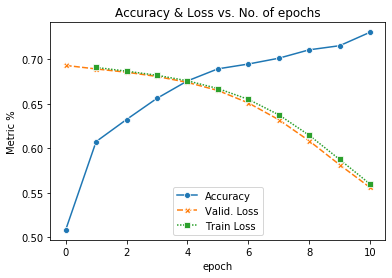

In [60]:
plot_metrics(history)

Label: O , Predicted: O


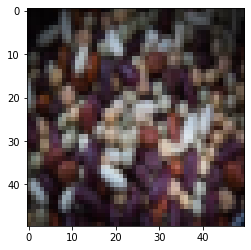

In [61]:
# Testing samples
img, label = test_dataset[950]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [62]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.5002542734146118, 'val_acc': 0.8069947957992554}

#### Save and Commit

In [64]:
torch.save(model.state_dict(), 'waste-cnn.pth')

In [65]:
!pip install jovian --upgrade --quiet

In [66]:
import jovian

In [67]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': learning_rate,
})

[jovian] Hyperparams logged.


In [69]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [70]:
jovian.commit(project=project_name, environment=None, outputs=['waste-cnn.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/or-waste-classif" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', OSError("(32, 'EPIPE')")) (waste-cnn.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/or-waste-classif


'https://jovian.ml/dan-motp/or-waste-classif'

## Intermediate Results
At this point 3 different models were ran: a Logistic Regression; a FeedForward NN and a simple CNN model. Surprisingly, results were very similar throughout the three models, with validation loss around 0.40 ~ 0.50 and validation accuracy of around 80% ~ 84%. We could possibly be hindering our NN models with our hyperparameters choices, specially with the small number of epochs used, as the metric plots show there could be space for more improvement until losses start rising and overfitting occurs. We could also be having some other limitations with other design choices, such as the learning rate and the validation dataset could be too small.

## Testing with more epochs

In [71]:
epochs = 50

### Logistic Model

In [72]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [73]:
model = WasteLogistModel()

In [74]:
evaluate(model, val_loader)

{'val_loss': 0.7080584764480591, 'val_acc': 0.503508985042572}

In [75]:
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5246, val_acc: 0.7508
Epoch [1], val_loss: 0.5317, val_acc: 0.7401
Epoch [2], val_loss: 0.5012, val_acc: 0.7657
Epoch [3], val_loss: 0.5112, val_acc: 0.7542
Epoch [4], val_loss: 0.4980, val_acc: 0.7681
Epoch [5], val_loss: 0.4997, val_acc: 0.7691
Epoch [6], val_loss: 0.4939, val_acc: 0.7659
Epoch [7], val_loss: 0.4939, val_acc: 0.7667
Epoch [8], val_loss: 0.4927, val_acc: 0.7721
Epoch [9], val_loss: 0.4922, val_acc: 0.7724
Epoch [10], val_loss: 0.5055, val_acc: 0.7669
Epoch [11], val_loss: 0.4926, val_acc: 0.7728
Epoch [12], val_loss: 0.4914, val_acc: 0.7762
Epoch [13], val_loss: 0.4935, val_acc: 0.7668
Epoch [14], val_loss: 0.4949, val_acc: 0.7730
Epoch [15], val_loss: 0.4914, val_acc: 0.7801
Epoch [16], val_loss: 0.4933, val_acc: 0.7729
Epoch [17], val_loss: 0.4936, val_acc: 0.7677
Epoch [18], val_loss: 0.5022, val_acc: 0.7613
Epoch [19], val_loss: 0.4953, val_acc: 0.7762
Epoch [20], val_loss: 0.4917, val_acc: 0.7762
Epoch [21], val_loss: 0.4985, val_acc: 0.774

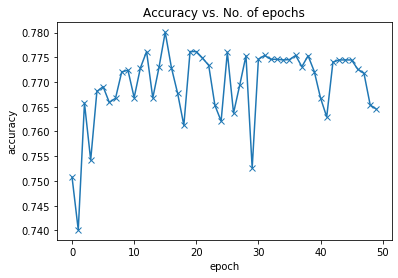

In [76]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [77]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.4469081163406372, 'val_acc': 0.8295847177505493}

### FeedForward Model

In [78]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [79]:
model = WasteFFModel(input_size, out_size=num_classes)
to_device(model, device)

WasteFFModel(
  (linear1): Linear(in_features=7500, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
)

In [80]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.7135040163993835, 'val_acc': 0.49152541160583496}]

In [81]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6832, val_loss: 0.6703, val_acc: 0.5445
Epoch [1], train_loss: 0.6453, val_loss: 0.6299, val_acc: 0.7054
Epoch [2], train_loss: 0.6055, val_loss: 0.5931, val_acc: 0.7552
Epoch [3], train_loss: 0.5700, val_loss: 0.5618, val_acc: 0.7506
Epoch [4], train_loss: 0.5417, val_loss: 0.5408, val_acc: 0.7549
Epoch [5], train_loss: 0.5234, val_loss: 0.5247, val_acc: 0.7553
Epoch [6], train_loss: 0.5119, val_loss: 0.5158, val_acc: 0.7528
Epoch [7], train_loss: 0.5043, val_loss: 0.5156, val_acc: 0.7573
Epoch [8], train_loss: 0.4995, val_loss: 0.5061, val_acc: 0.7562
Epoch [9], train_loss: 0.4958, val_loss: 0.5052, val_acc: 0.7642
Epoch [10], train_loss: 0.4930, val_loss: 0.5015, val_acc: 0.7641
Epoch [11], train_loss: 0.4906, val_loss: 0.4990, val_acc: 0.7617
Epoch [12], train_loss: 0.4893, val_loss: 0.4988, val_acc: 0.7682
Epoch [13], train_loss: 0.4870, val_loss: 0.4971, val_acc: 0.7689
Epoch [14], train_loss: 0.4855, val_loss: 0.4968, val_acc: 0.7713
Epoch [15], train_lo

In [82]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.4023009240627289, 'val_acc': 0.8419783115386963}

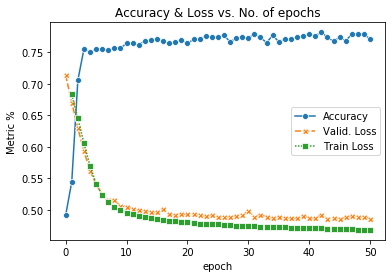

In [83]:
def plot_metrics(history):
    metrics = pd.DataFrame({'Accuracy': [x['val_acc'] for x in history], 
                            'Valid. Loss': [x['val_loss'] for x in history],
                           'Train Loss': [x.get('train_loss') for x in history]})

    sns.lineplot(data=metrics, markers=True, hue=metrics.columns)

    plt.xlabel('epoch')
    plt.ylabel('Metric %')
    plt.legend(['Accuracy', 'Valid. Loss', 'Train Loss'])
    plt.title('Accuracy & Loss vs. No. of epochs');
    
plot_metrics(history)

### CNN Model

In [84]:
model = WasteCnnModel()
to_device(model, device)

WasteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=40000, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [85]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.693122148513794, 'val_acc': 0.506912112236023}]

In [86]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6898, val_loss: 0.6888, val_acc: 0.5010
Epoch [1], train_loss: 0.6859, val_loss: 0.6859, val_acc: 0.5169
Epoch [2], train_loss: 0.6825, val_loss: 0.6823, val_acc: 0.5789
Epoch [3], train_loss: 0.6782, val_loss: 0.6777, val_acc: 0.6297
Epoch [4], train_loss: 0.6723, val_loss: 0.6712, val_acc: 0.6798
Epoch [5], train_loss: 0.6642, val_loss: 0.6621, val_acc: 0.6962
Epoch [6], train_loss: 0.6529, val_loss: 0.6498, val_acc: 0.7045
Epoch [7], train_loss: 0.6370, val_loss: 0.6319, val_acc: 0.7153
Epoch [8], train_loss: 0.6154, val_loss: 0.6084, val_acc: 0.7248
Epoch [9], train_loss: 0.5882, val_loss: 0.5801, val_acc: 0.7339
Epoch [10], train_loss: 0.5586, val_loss: 0.5521, val_acc: 0.7469
Epoch [11], train_loss: 0.5328, val_loss: 0.5296, val_acc: 0.7523
Epoch [12], train_loss: 0.5147, val_loss: 0.5150, val_acc: 0.7564
Epoch [13], train_loss: 0.5030, val_loss: 0.5058, val_acc: 0.7643
Epoch [14], train_loss: 0.4964, val_loss: 0.4985, val_acc: 0.7674
Epoch [15], train_lo

In [87]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.3541226387023926, 'val_acc': 0.8661771416664124}

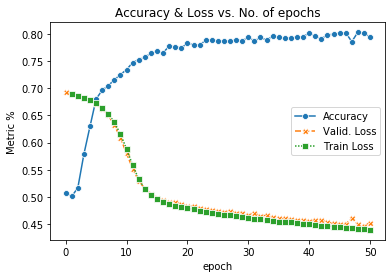

In [88]:
plot_metrics(history)

Our models performed just slightly better with val_loss 0.35 ~ 0.45 and val_accuracy 84% ~ 86%, except the Logistic Model where val_accuracy remained in the 80% range for the test dataset. The assumption that more epochs would resolve our problem were not precisely correct, as the models' training seem to stagnate around the 80% accuracy. We have not yet faced compromisable overfitting issues which is good.

We can move forward and experiment further with the learning rate on the CNN model.

## Fine-tuning with One Cycle learning rate scheduler

In [101]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [102]:
model = WasteCnnModel()
to_device(model, device)

WasteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=40000, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [103]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6929857134819031, 'val_acc': 0.508474588394165}]

In [104]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [105]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], train_loss: 0.6464, val_loss: 0.5166, val_acc: 0.7446
Epoch [1], train_loss: 0.4835, val_loss: 0.4864, val_acc: 0.7836
Epoch [2], train_loss: 0.4639, val_loss: 0.4633, val_acc: 0.7839
Epoch [3], train_loss: 0.4457, val_loss: 0.4426, val_acc: 0.7977
Epoch [4], train_loss: 0.4270, val_loss: 0.4432, val_acc: 0.8061
Epoch [5], train_loss: 0.4023, val_loss: 0.3998, val_acc: 0.8203
Epoch [6], train_loss: 0.3779, val_loss: 0.3957, val_acc: 0.8201
Epoch [7], train_loss: 0.3647, val_loss: 0.3788, val_acc: 0.8393
Epoch [8], train_loss: 0.3426, val_loss: 0.3616, val_acc: 0.8474
Epoch [9], train_loss: 0.3298, val_loss: 0.3606, val_acc: 0.8505
CPU times: user 5min 27s, sys: 2min 24s, total: 7min 51s
Wall time: 8min


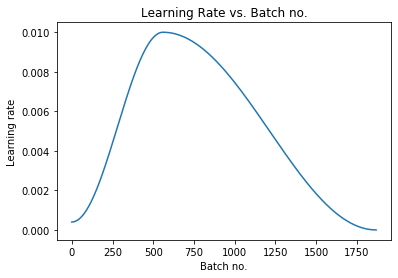

In [106]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

In [107]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.28368106484413147, 'val_acc': 0.88796067237854}

#### Save and Commit

In [109]:
torch.save(model.state_dict(), 'waste-cnn-cycle.pth')

In [110]:
!pip install jovian --upgrade --quiet

In [111]:
import jovian

In [112]:
jovian.reset()
jovian.log_hyperparams(arch='cnn', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [113]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [114]:
jovian.commit(project=project_name, environment=None, outputs=['waste-cnn-cycle.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/or-waste-classif" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', OSError("(32, 'EPIPE')")) (waste-cnn-cycle.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/or-waste-classif


'https://jovian.ml/dan-motp/or-waste-classif'

Experimenting by fine-tuning the learning rate with One Cycle scheduler yielded better test results, validation loss slightly crossed the 0.30 and managed to reach about 89% of validation accuracy, all within 10 epochs.

## Testing Adam optimizer

In [115]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [116]:
# Hyperparmeters
batch_size = 128
epochs = 10
learning_rate = 0.001

# Other constants
input_size = 3*50*50
num_classes = 2
opt_func = torch.optim.Adam

In [117]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class WasteClassBase(nn.Module):    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [118]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [119]:
class WasteCnnModel(WasteClassBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 25 x 25

            nn.Flatten(), 
            nn.Linear(64*25*25, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [120]:
model = WasteCnnModel()
to_device(model, device)

WasteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=40000, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [121]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6936448216438293, 'val_acc': 0.508474588394165}]

In [122]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [123]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], train_loss: 0.6478, val_loss: 0.5301, val_acc: 0.7222
Epoch [1], train_loss: 0.4934, val_loss: 0.4723, val_acc: 0.7945
Epoch [2], train_loss: 0.4621, val_loss: 0.4524, val_acc: 0.8012
Epoch [3], train_loss: 0.4493, val_loss: 0.4481, val_acc: 0.7993
Epoch [4], train_loss: 0.4274, val_loss: 0.4206, val_acc: 0.7965
Epoch [5], train_loss: 0.4121, val_loss: 0.4104, val_acc: 0.8029
Epoch [6], train_loss: 0.3915, val_loss: 0.3969, val_acc: 0.8236
Epoch [7], train_loss: 0.3672, val_loss: 0.3899, val_acc: 0.8356
Epoch [8], train_loss: 0.3513, val_loss: 0.3773, val_acc: 0.8457
Epoch [9], train_loss: 0.3373, val_loss: 0.3745, val_acc: 0.8393
CPU times: user 5min 25s, sys: 2min 22s, total: 7min 48s
Wall time: 7min 56s


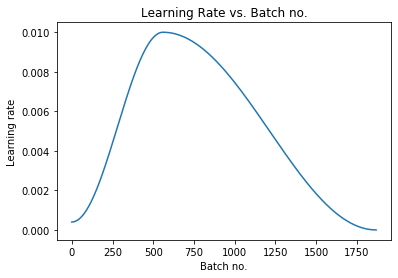

In [124]:
plot_lrs(history)

In [125]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.28934016823768616, 'val_acc': 0.885855495929718}

#### Save and Commit

In [127]:
torch.save(model.state_dict(), 'waste-cnn-adam-cycle.pth')

In [128]:
!pip install jovian --upgrade --quiet

In [129]:
import jovian

In [130]:
jovian.reset()
jovian.log_hyperparams(arch='cnn', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [131]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [132]:
jovian.commit(project=project_name, environment=None, outputs=['waste-cnn-adam-cycle.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "dan-motp/or-waste-classif" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', OSError("(32, 'EPIPE')")) (waste-cnn-adam-cycle.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/dan-motp/or-waste-classif


'https://jovian.ml/dan-motp/or-waste-classif'

## Conclusions

Thanks to the convolutional layers, the CNN model presented less training and validation losses than the FeedForward method, even though validation accuracy was slightly behind. Complemented with One Cycle learning rate and the Adam optimizer the model almost reached 90% accuracy. 
Accounting that only basic models were used, the results were not so much satisfying although the complexity of the model is fairly low, which also presents opportunity for even further experimenting.

### Future recommendations

We should keep in mind that no modifications were yet made regarding the optimizer, loss function and activation layers. For future implementations the following are recommended and should be considered:
* Binary Cross Entropy loss
* Leaky_relu with He initializer; tanh activator with Xavier initializer
* More, deeper, Conv2 layers
* Dropout layers
* Batch normalization
* Input data augmentation/transformations
* bigger validation set

### References

1. https://www.kaggle.com/techsash/waste-classification-data accessed on 21/06/2020
2. https://www.kaggle.com/arkadiyhacks/drinking-waste-classification accessed on 21/06/2020
3. https://jovian.ml/forum/t/assignment-5-course-project/1563